In [37]:
import random

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression

from simulation import generate_dataset

In [38]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')
random.seed(42)

In [39]:
d_list = [100, 100, 100]
scalars = [0.6, 0.3, 0.1]
n_targets = 10000
n_samples_train = 1000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [40]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
use_ols = False
i_from = 0
i_to = 1

In [41]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar, construction_method="orthogonal")

first of all lets verify that Ridge regression with $\alpha = 0$ indeed is equivalent to linear regression

In [42]:
fit_intercept = True

ridge = Ridge(alpha=1, fit_intercept=fit_intercept, solver_params=dict(warn=False, n_targets_batch=1000))
ridge.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
ridge_coef = ridge.coef_  # (n_features, n_targets)

In [43]:
linear = LinearRegression(fit_intercept=fit_intercept)
linear.fit(backend.to_numpy(Xs[0][:n_samples_train]), backend.to_numpy(Y[:n_samples_train]))
linear_coef = linear.coef_  # (n_targets, n_features)
# swap rows and columns
linear_coef = linear_coef.T

In [44]:
assert np.allclose(linear_coef, ridge_coef, atol=1e-4)
assert np.allclose(ridge.intercept_, linear.intercept_, atol=1e-4)


compute on full feature sets for comparison

0.83024246
0.54130065


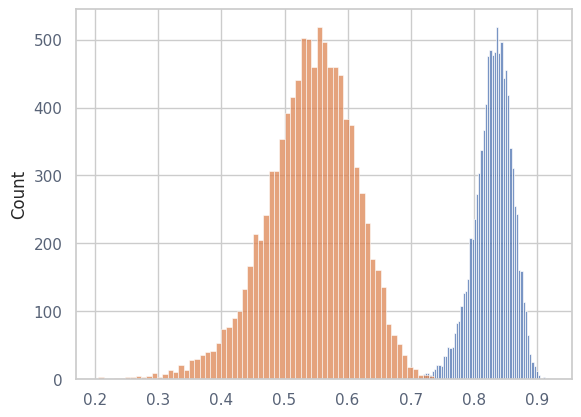

In [45]:
for i in range(len(Xs)):
    full_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
    full_model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    full_score = full_model.score(Xs[i][n_samples_train:], Y[n_samples_train:])
    print(full_score.mean())
    sns.histplot(backend.to_numpy(full_score))

# Feature to feature regression

In [46]:
if use_ols:
    feature_model = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
else:
    feature_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)

In [47]:
feature_model.fit(Xs[i_from][:n_samples_train], Xs[i_to][:n_samples_train])

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=10,
        solver_params={'n_targets_batch': 1000,
                       'score_func': <function r2_score at 0x7fe08263c860>,
                       'warn': False})

In [48]:
X_predict_train = feature_model.predict(Xs[i_from][:n_samples_train])
X_predict_test = feature_model.predict(Xs[i_from][:n_samples_test])

In [49]:
X_predict_train = backend.asarray(X_predict_train)
X_predict_test = backend.asarray(X_predict_test)

<Axes: ylabel='Count'>

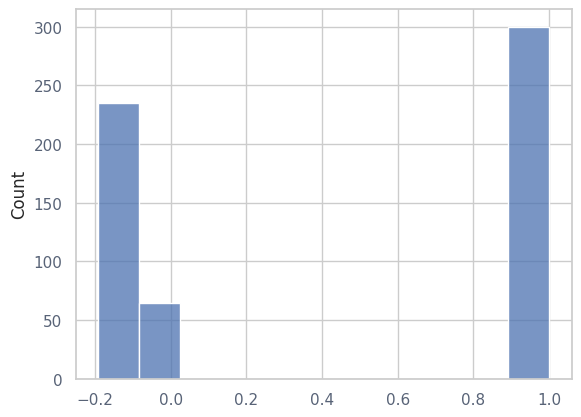

In [50]:
feature_score = feature_model.score(Xs[i_from][n_samples_train:], Xs[i_to][n_samples_train:])
sns.histplot(backend.to_numpy(feature_score))

Compute residuals

In [51]:
X_residual_train = Xs[i_to][:n_samples_train] - X_predict_train
X_residual_test = Xs[i_to][n_samples_train:] - X_predict_test

# Train residual model

0.0052316007


<Axes: ylabel='Count'>

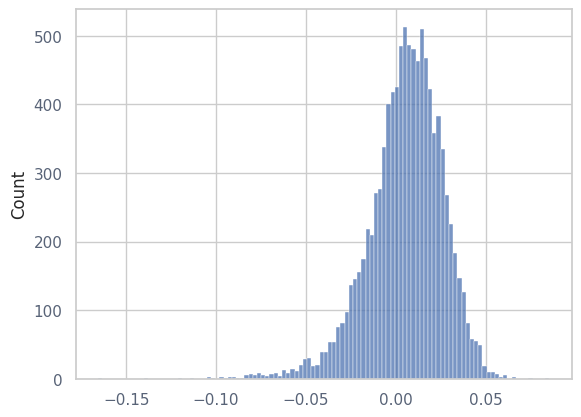

In [52]:
residual_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
residual_model.fit(X_residual_train, Y[:n_samples_train])
residual_score = residual_model.score(X_residual_test, Y[n_samples_train:])
print(residual_score.mean())
sns.histplot(backend.to_numpy(residual_score))